# Pixel classification on OpenCL-compatible GPUs
OCLRFC is based on [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) and [sklearn](https://scikit-learn.org/stable/).

Let's start with loading an example image and some ground truth:

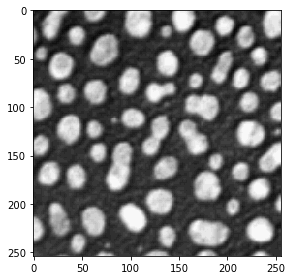

In [1]:
from skimage.io import imread, imshow
image = imread('blobs.tif')
imshow(image)

In [2]:
if False: # you can use this to make manual annotations
    import numpy as np
    import napari

    # start napari
    viewer = napari.Viewer()
    napari.run()

    # add image
    viewer.add_image(image)

    # add an empty labels layer and keep it in a variable
    labels = np.zeros(image.shape).astype(int)
    viewer.add_labels(labels)
else:
    labels = imread('annotations.tif')

C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


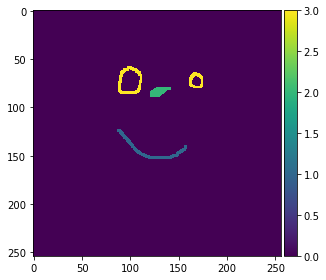

In [3]:
manual_annotations = labels

from skimage.io import imshow
imshow(manual_annotations, vmin=0, vmax=3)

## Feature stacks
A feature stack is a list of 2D or 3D images, typically derived from an original image.

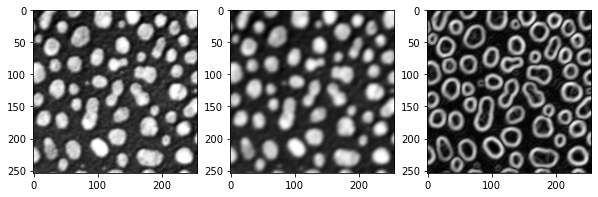

In [4]:
from oclrfc import generate_feature_stack


feature_stack = generate_feature_stack(image)

# show feature images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(10,10))

# reshape(image.shape) is the opposite of ravel() here. We just need it for visualization.
axes[0].imshow(feature_stack[0], cmap=plt.cm.gray)
axes[1].imshow(feature_stack[1], cmap=plt.cm.gray)
axes[2].imshow(feature_stack[2], cmap=plt.cm.gray)

## Training
We now train a OCLRandomForestClassifier, which is under the hood a [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). After training, the classifier will be converted to [clij-compatible OpenCL code](https://github.com/clEsperanto/clij-opencl-kernels) and save to disk under a given filename.

In [5]:
from oclrfc import OCLRandomForestClassifier
import numpy as np

num_features = len(feature_stack)
num_classes = np.max(manual_annotations)
cl_filename = 'my_model.cl'

clf = OCLRandomForestClassifier(num_features, num_classes, opencl_filename=cl_filename)
clf.train(feature_stack, manual_annotations)

## Prediction
The classifier can then be used to classify all pixels in the given image. Starting point is again, the feature stack. Thus, the user must make sure that the same features are used for training and for prediction. Prediction can be done on the CPU using the original scikit-learn code and on the GPU using the generated OpenCL-code. OCLRFC works well if both result images look identical.

In [6]:
# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
import pyclesperanto_prototype as cle
cle.set_wait_for_kernel_finish(True)
# print out which GPU is used
cle.get_device()

<GeForce RTX 2080 Ti on Platform: NVIDIA CUDA (2 refs)>

cpu prediction took 0.03992438316345215 s
cpu prediction took 0.023082256317138672 s
cpu prediction took 0.025194644927978516 s
cpu prediction took 0.031246185302734375 s
cpu prediction took 0.03127121925354004 s
cpu prediction took 0.03302931785583496 s
cpu prediction took 0.02793121337890625 s
cpu prediction took 0.02064037322998047 s
cpu prediction took 0.03980565071105957 s
cpu prediction took 0.025022506713867188 s


C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


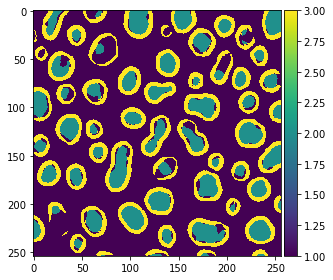

In [7]:
import time
for i in range(0, 10):
    start_time = time.time()
    result = clf.predict(feature_stack)
    print("cpu prediction took " + str(time.time() - start_time) + " s")
imshow(result)

cpu prediction took 0.009319543838500977 s
cpu prediction took 0.000997304916381836 s
cpu prediction took 0.0009942054748535156 s
cpu prediction took 0.0009975433349609375 s
cpu prediction took 0.0 s
cpu prediction took 0.0009975433349609375 s
cpu prediction took 0.0009970664978027344 s
cpu prediction took 0.0 s
cpu prediction took 0.0009980201721191406 s
cpu prediction took 0.0010073184967041016 s


C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


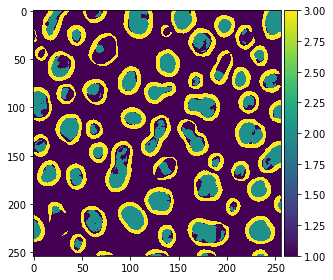

In [8]:
import time
for i in range(0, 10):
    start_time = time.time()
    result = clf.predict_gpu(feature_stack)
    print("cpu prediction took " + str(time.time() - start_time) + " s")
imshow(result)